In [1]:
import math

In [2]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op="+")
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
    
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), _op='*')
        
        def _backward():
            self.grad += other.data * out.grad
            out.grad += self.data * out.grad
        
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")
        
        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    
    def __truediv__(self, other):
        return self * (other**(-1))
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def exp(self, taylor_order):
        out = 1
        factorial = 1
        for i in range(1, taylor_order+1):
            factorial = factorial * i
            out = (self**i)/factorial + out
        
        
        return out
    
    def tanh(self, taylor_order):
        out = ((2*self).exp(taylor_order) - 1) / ((2*self).exp(taylor_order) + 1)
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

In [3]:
from graphviz import Digraph

In [4]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [5]:
a = Value(2.0, label="a")
b = a.exp(3); b.label = "b"

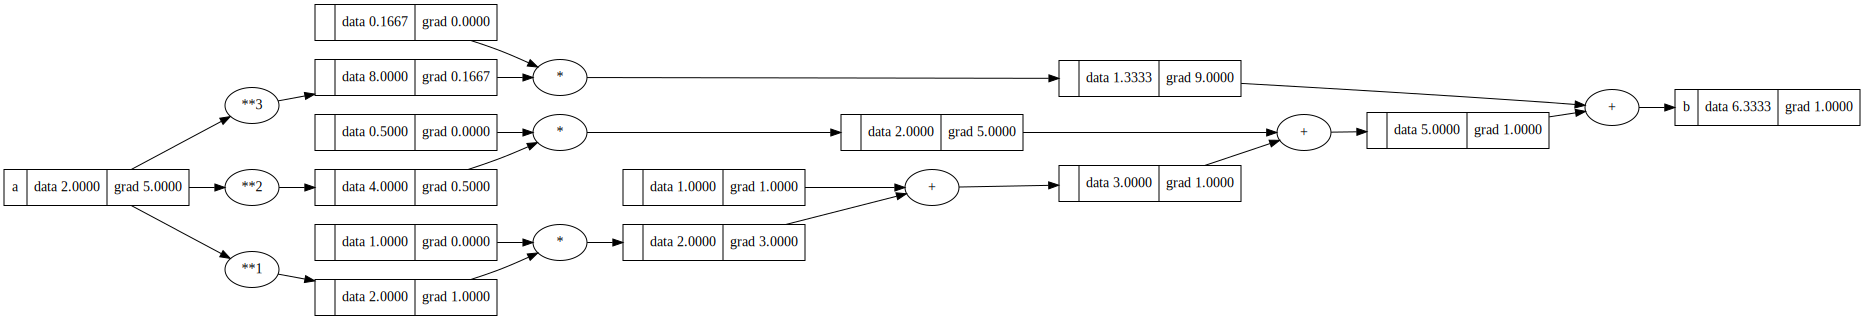

In [6]:
b.backward()
draw_dot(b)

In [7]:
a = Value(2.0, label="a")
b = a.exp(10); b.label = "b"

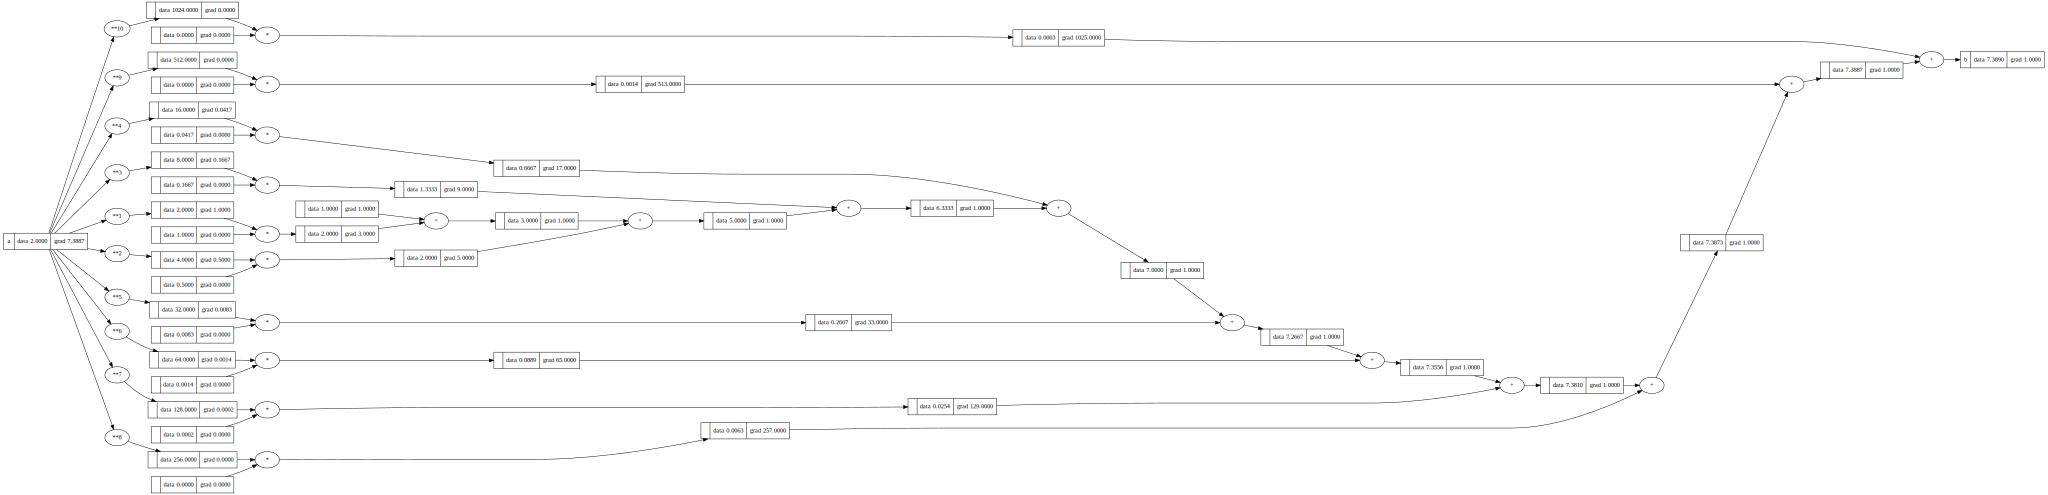

In [8]:
b.backward()
draw_dot(b)

In [9]:
a = Value(2.0, label="a")
c = a.tanh(3); c.label = "c"

In [10]:
c.backward()

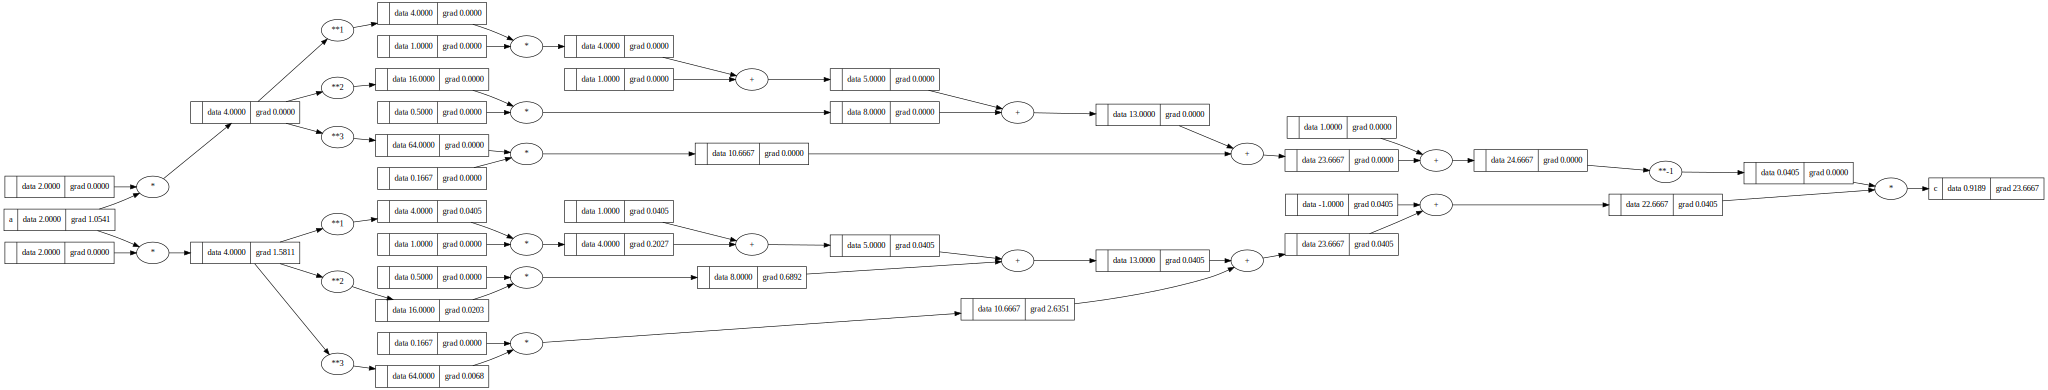

In [11]:
draw_dot(c)